In [1]:
import os
import logging
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

# Configure logging to suppress TensorFlow messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Set level to ERROR to suppress INFO and WARNING messages


In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset

import tensorflow as tf
from tensorflow.keras import layers


In [3]:
dataset = load_dataset("x-g85/x_g85_fn_dataset", streaming=True)

train = pd.DataFrame(dataset["train"])
valid = pd.DataFrame(dataset["valid"])
test = pd.DataFrame(dataset["test"])

In [4]:
X_train = train["text"]
y_train = train["label"]

X_valid = valid["text"]
y_vaild = valid["label"]

X_test = test["text"]
y_test = test["label"]


In [5]:
X_train[0].split()

['John',
 'McCain',
 'says',
 'NSA',
 'chief',
 'Keith',
 'Alexander',
 "'should",
 'resign',
 'or',
 'be',
 "fired'.",
 'Senator',
 'gives',
 'interview',
 'to',
 'Der',
 'Spiegel,',
 'saying',
 'general',
 'should',
 "'be",
 'held',
 "accountable'",
 'for',
 'Edward',
 'Snowden',
 'leaks.']

In [6]:
# Calculate the rounded average number of words per sentence in one line
rounded_average_words_per_sentence = round(sum(len(sentence.split()) for sentence in X_train) / len(X_train))

rounded_average_words_per_sentence

207

In [7]:
# Text Tokenization | Vectorization Parameters
max_vocab_length = 5000 # how many unique words to use (i.e num rows in embedding vector)
max_length = 300 # max number of words in a comment to use; default = 300
embed_dim = 256 # how big is each word vector

In [8]:
# Setup Text Vectorization
# Serialization Issue: https://github.com/onnx/tensorflow-onnx/issues/1886

text_vectorizer  = layers.TextVectorization(
    max_tokens= max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length,
    name="TextVec",
    
)

text_vectorizer.adapt(X_train, batch_size=32)

In [9]:
# # Setup Text Tokenizer
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words=max_vocab_length)
# tokenizer.fit_on_texts(X_train)


# tokenized_train = tokenizer.texts_to_sequences(X_train)
# tokenized_valid= tokenizer.texts_to_sequences(X_valid)
# tokenized_test = tokenizer.texts_to_sequences(X_test)

# X_train = pad_sequences(tokenized_train, maxlen=max_length)
# X_valid = pad_sequences(tokenized_valid, maxlen=max_length)
# X_test = pad_sequences(tokenized_test, maxlen=max_length)


# # Save the tokenizer to a JSON file
# tokenizer_json = tokenizer.to_json()
# with open('model/tokenizer.json', 'w') as file:
#     file.write(tokenizer_json)

In [10]:

# Model Creation
# Issue(Serialization): https://github.com/tflearn/tflearn/issues/605

# Input
inputs = layers.Input(shape=(1,), dtype=tf.string,  name="InputLayer") # For TextVectorization
x = text_vectorizer(inputs) # For TextVectorization

# inputs = layers.Input(shape=(max_length,),  name="InputLayer")

# Embedding layer

x = layers.Embedding(input_dim=max_vocab_length, output_dim=embed_dim)(x) # For TextVectorization
# x = layers.Embedding(input_dim=max_vocab_length, output_dim=embed_dim)(inputs) 

# LSTM layers
x = layers.LSTM(100, use_cudnn=False)(x) # LSTM layer without return_sequences
x = layers.Dropout(0.5)(x)  # Reduce dropout rate slightly

# Fully connected layers
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(1, activation="sigmoid")(x)  # Binary classification



In [11]:
model_01= tf.keras.Model(inputs, outputs, name = "model_01")

In [12]:
# Get the summary
model_01.summary()

Model: "model_01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TextVec (TextVectorization)     │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 256)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,431,377 (5.46 MB)

 Trainable params: 1,431,377 (5.46 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model Compile
from tensorflow.keras.metrics import AUC, Precision 

model_01.compile(loss="binary_crossentropy",
                   optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics = ["accuracy", Precision(), AUC()])

In [14]:
import os

model_logs = "model_logs"

# Check if the `model_logs` directory exists, create it if not
if not os.path.exists(model_logs):
    os.makedirs(model_logs)
    print(f"Folder created at: {model_logs}")
else:
    print(f"Folder already exists at: {model_logs}")

Folder already exists at: model_logs


In [15]:

# Early Stopping
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Model Fit

history_model_01 = model_01.fit(X_train, y_train, epochs=10, batch_size=32,
                                 validation_data = (X_valid, y_vaild),
                                 callbacks = [tf.keras.callbacks.TensorBoard("model_logs")])

Epoch 1/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 1773s 659ms/step - accuracy: 0.5918 - auc: 0.6342 - loss: 0.6441 - precision: 0.5722 - val_accuracy: 0.7242 - val_auc: 0.8294 - val_loss: 0.4581 - val_precision: 0.6573
Epoch 2/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 1743s 652ms/step - accuracy: 0.7226 - auc: 0.8324 - loss: 0.4403 - precision: 0.6735 - val_accuracy: 0.7320 - val_auc: 0.8443 - val_loss: 0.4240 - val_precision: 0.6555
Epoch 3/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 1795s 671ms/step - accuracy: 0.7393 - auc: 0.8508 - loss: 0.3992 - precision: 0.6759 - val_accuracy: 0.7465 - val_auc: 0.8536 - val_loss: 0.3860 - val_precision: 0.6696
Epoch 4/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 1776s 664ms/step - accuracy: 0.7488 - auc: 0.8573 - loss: 0.3855 - precision: 0.6789 - val_accuracy: 0.7474 - val_auc: 0.8587 - val_loss: 0.3812 - val_precision: 0.6682
Epoch 5/10
2674/2674 ━━━━━━━━━━━━━━━━━━━━ 1795s 671ms/step - accuracy: 0.7519 - auc: 0.8631 - loss: 0.3734 - precision: 0.6765 - val_accuracy: 0.7493 - val_

In [16]:
# Model Prediction
model_01_pred_probs = model_01.predict(X_test)
model_01_pred_probs[:5]

149/149 ━━━━━━━━━━━━━━━━━━━━ 33s 211ms/step


array([[0.9999999 ],
       [0.5088127 ],
       [0.51265997],
       [0.51331687],
       [0.51750326]], dtype=float32)

In [17]:
# Helper Functions

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support



def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [18]:
# Convert model 2 pred probability to labels
model_01_preds = tf.squeeze(tf.round(model_01_pred_probs))
model_01_preds[:1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>

In [19]:
calculate_results(y_true=y_test, y_pred=model_01_preds)

{'accuracy': 74.98948254101809,
 'precision': 0.7918142582139361,
 'recall': 0.7498948254101809,
 'f1': 0.7373717047030267}

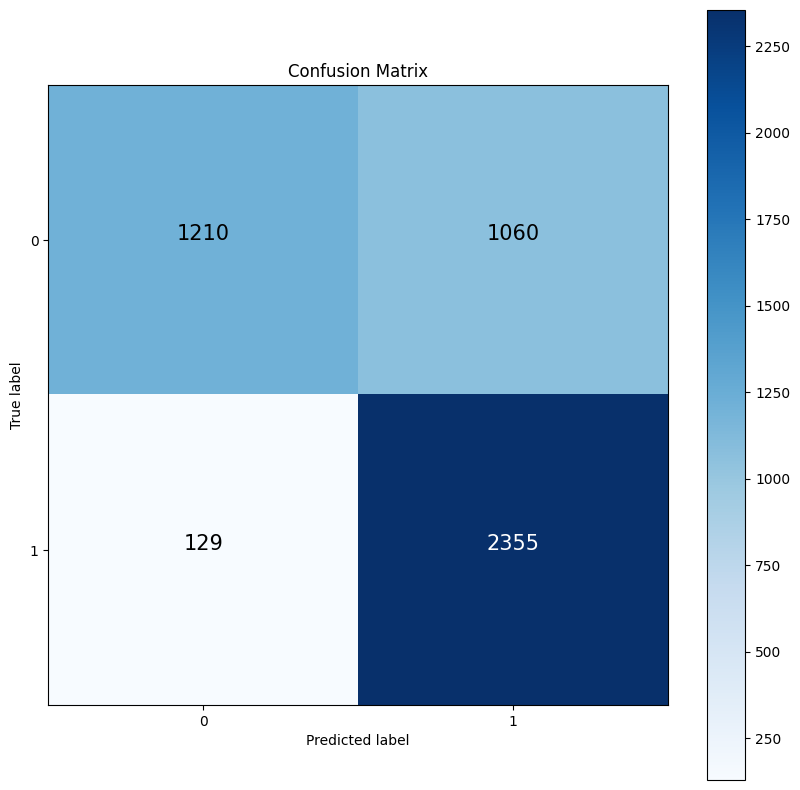

In [20]:
make_confusion_matrix(y_true = y_test, y_pred = model_01_preds)

In [21]:
import tf2onnx
import onnx

In [22]:

model_01.save("model/x_g85_lstm.keras")

In [23]:
# # Define the input signature
# input_signature = [tf.TensorSpec((None, 1), dtype=tf.string, name="input")] # For `TextVectorization`

# # input_signature = [tf.TensorSpec((None, max_length), name="input")]

# # Convert the Keras model to ONNX
# onnx_model, _ = tf2onnx.convert.from_keras(model_01, input_signature, opset=18, 
#                                            custom_ops={
#                                                "StaticRegexReplace": "ai.onnx.contrib", # For TextVectorization
#                                                "StringSplitV2": "ai.onnx.contrib", # For TextVectorization
#                                                })

# # Save the ONNX model
# onnx.save(onnx_model, "model/x_g85_lstm.onnx")